In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from IC.invisible_cities.io.pmaps_io        import load_pmaps

from   IC.invisible_cities.database           import load_db
from   IC.invisible_cities.io.pmaps_io        import load_pmaps
from   IC.invisible_cities.io.pmaps_io        import load_pmaps_as_df
from   IC.invisible_cities.io.pmaps_io        import s1s_from_df
from   IC.invisible_cities.io.pmaps_io        import s2s_from_df

from   IC.invisible_cities.core.exceptions        import ClusterEmptyList
from   IC.invisible_cities.core.exceptions        import SipmZeroCharge
from   IC.invisible_cities.core.exceptions        import SipmEmptyListAboveQthr

from IC.invisible_cities.reco                 import pmaps_functions  as pmp
from IC.invisible_cities.reco.xy_algorithms   import corona
from IC.invisible_cities.reco.pmaps_functions import rebin_peak
import IC.invisible_cities.io.dst_io         as     dstio
from IC.invisible_cities.core                 import system_of_units as units
from IC.invisible_cities.reco.xy_algorithms import barycenter
from IC.invisible_cities.reco.xy_algorithms import get_nearby_sipm_inds
from IC.invisible_cities.reco.xy_algorithms import count_masked
from IC.invisible_cities.reco.xy_algorithms import discard_sipms

from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm

from IC.invisible_cities.database import load_db
datasipm = load_db.DataSiPM("flex100", 0)
datasipm_n100 = load_db.DataSiPM("next100", 0)

In [2]:
eventid = 101802

## NEXT FLEX

In [3]:
filepath = '/Users/halmamol/NEXT/files/NFLEX/psf_202012/kr_penthesilea/'
filname_base = 'nflex_d15_M6_H6.kr83m'
maxnfiles = 999

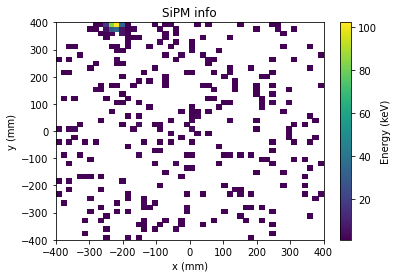

In [4]:
filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_100_kr83m.h5'

S2Si = pd.read_hdf(filename, "/PMAPS/S2Si")
S2Si = S2Si.set_index(["event", "peak"])
# choose random event
#event = np.random.choice(S2Si.index.get_level_values("event").unique())
event = eventid
event_sipm_response = S2Si.loc[event, 0] # peak 0

charges = event_sipm_response.groupby("nsipm").ene.sum().to_frame()

select_sipms = datasipm.loc[charges.index.get_level_values("nsipm")]
xsipm, ysipm = select_sipms["X"].values, select_sipms["Y"].values
charge = charges["ene"].values
plt.hist2d(xsipm, ysipm,  bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=charge,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')

In [5]:
cluster = []
possipm = []

slice_reco_params = dict(                                                                                                                                                      
                  Qthr            =  0.1 * units.pes,                                                                                                                              
                  Qlm             =  5. * units.pes ,#   * pes                                                                                                                              
                  lm_radius       =  0.01 * units.mm,# * mm                                                                                                                                
                  new_lm_radius   =  0.01 * units.mm ,#* mm                                                                                                                                
                  msipm           =  1         ,
                consider_masked = True)

pos1 = [0,0]
for xi,yi in zip(xsipm,ysipm):
    pos1 = [xi,yi]
    possipm.append(pos1)

    
posXY = np.array([np.array([x,y]) for x,y in zip(xsipm, ysipm)])
Qs  = np.array(charge)
#charge
#cluster = corona(posXY, Qs, datasipm, slice_reco_params)
#within_lm_radius  = get_nearby_sipm_inds(posXY[np.argmax(charge)], 0.01, posXY)
#barycenter(posXY[within_lm_radius], charge[within_lm_radius])[0].posxy


In [6]:
pos = posXY
qs = Qs
all_sipms = datasipm
Qthr            =  5. * units.pes
Qlm             =  5. * units.pes
lm_radius       =  0.01 * units.mm
new_lm_radius   = 0.01 * units.mm
msipm           =  1
consider_masked = False

In [7]:
if not len(pos)   : raise SipmEmptyList
if np.sum(qs) == 0: raise SipmZeroCharge
print(len(qs))
print(len(pos))
masked = all_sipms.Active.values.astype(bool) if consider_masked else None
above_threshold = np.where(qs >= Qthr)[0]   # Find SiPMs with qs at least Qthr

print(len(above_threshold))

pos, qs = pos[above_threshold], qs[above_threshold]  # Discard SiPMs with qs less than Qthr

if not len(pos)   : raise SipmEmptyListAboveQthr
if np.sum(qs) == 0: raise SipmZeroChargeAboveQthr
    
print(len(qs))
print(len(pos))

369
369
16
16
16


In [8]:
c  = []
# if lm_radius or new_lm_radius is negative, just call overall barycenter
if lm_radius < 0 or new_lm_radius < 0:
    c = barycenter(pos, qs)



# While there are more local maxima
while len(qs) > 0:

    hottest_sipm = np.argmax(qs)       # SiPM with largest Q
    if qs[hottest_sipm] < Qlm: break   # largest Q remaining is negligible

    # find new local maximum of charge considering all SiPMs within lm_radius of hottest_sipm
    within_lm_radius  = get_nearby_sipm_inds(pos[hottest_sipm], lm_radius, pos)
    new_local_maximum = barycenter(pos[within_lm_radius], qs[within_lm_radius])[0].posxy

    # find the SiPMs within new_lm_radius of the new local maximum of charge
    within_new_lm_radius = get_nearby_sipm_inds(new_local_maximum, new_lm_radius, pos      )
    n_masked_neighbours  = count_masked        (new_local_maximum, new_lm_radius, all_sipms, masked)

    # if there are at least msipms within_new_lm_radius, taking
    # into account any masked channel, get the barycenter
    if len(within_new_lm_radius) >= msipm - n_masked_neighbours:
        c.extend(barycenter(pos[within_new_lm_radius], qs[within_new_lm_radius]))

    # delete the SiPMs contributing to this cluster
    pos, qs = discard_sipms(within_new_lm_radius, pos, qs)

if not len(c): raise ClusterEmptyList

c

[< nsipm = 1 Q = 102.31884002685547
                     xy = xy(x=-217.7, y=388.75) 3dHit = Cluster(-217.7, 388.75, -9.425, E=102.31884002685547)  >,
 < nsipm = 1 Q = 83.4202880859375
                     xy = xy(x=-233.25, y=388.75) 3dHit = Cluster(-233.25, 388.75, -9.425, E=83.4202880859375)  >,
 < nsipm = 1 Q = 80.86956787109375
                     xy = xy(x=-217.7, y=404.3) 3dHit = Cluster(-217.7, 404.3, -9.425, E=80.86956787109375)  >,
 < nsipm = 1 Q = 51.65217208862305
                     xy = xy(x=-233.25, y=404.3) 3dHit = Cluster(-233.25, 404.3, -9.425, E=51.65217208862305)  >,
 < nsipm = 1 Q = 34.956520080566406
                     xy = xy(x=-217.7, y=373.2) 3dHit = Cluster(-217.7, 373.2, -9.425, E=34.956520080566406)  >,
 < nsipm = 1 Q = 34.72463607788086
                     xy = xy(x=-202.15, y=388.75) 3dHit = Cluster(-202.15, 388.75, -9.425, E=34.72463607788086)  >,
 < nsipm = 1 Q = 29.101449966430664
                     xy = xy(x=-233.25, y=373.2) 3dHit = Cluster(-23

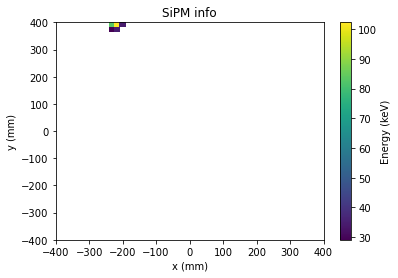

In [9]:
filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_100_kr83m.h5'

S2Si = pd.read_hdf(filename, "/PMAPS/S2Si")
S2Si = S2Si.set_index(["event", "peak"])
# choose random event
#event = np.random.choice(S2Si.index.get_level_values("event").unique())
event = eventid
event_sipm_response = S2Si.loc[event, 0] # peak 0

charges = event_sipm_response.groupby("nsipm").ene.sum().to_frame()
charges_th = charges[charges.ene > 25.]

select_sipms = datasipm.loc[charges_th.index.get_level_values("nsipm")]
xsipm, ysipm = select_sipms["X"].values, select_sipms["Y"].values
charge = charges_th["ene"].values
plt.hist2d(xsipm, ysipm,  bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=charge,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')

In [10]:
filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_100_kr83m.h5'
h5file_true = pd.read_hdf(filename, '/MC/hits')

true_evt = h5file_true[h5file_true.event_id == eventid]
true_evt

,event_id,particle_id,hit_id,x,y,z,time,energy,label
48893,101802,2,0,-221.498520,393.612701,705.312012,0.000075,0.001275,ACTIVE
48894,101802,2,1,-221.500809,393.612244,705.309448,0.000140,0.000315,ACTIVE
48895,101802,2,2,-221.503067,393.611755,705.307068,0.000204,0.000013,ACTIVE
48896,101802,2,3,-221.505051,393.611206,705.304565,0.000267,0.000219,ACTIVE
48897,101802,2,4,-221.506714,393.610046,705.302429,0.000325,0.000186,ACTIVE
48898,101802,2,5,-221.509628,393.602692,705.300903,0.000485,0.003694,ACTIVE
48899,101802,2,6,-221.509003,393.602570,705.301636,0.000512,0.000154,ACTIVE
48900,101802,2,7,-221.507248,393.601990,705.303650,0.000590,0.001823,ACTIVE
48901,101802,2,8,-221.507370,393.602142,705.303833,0.000600,0.000017,ACTIVE
48902,101802,2,9,-221.507629,393.602112,705.304016,0.000614,0.000123,ACTIVE


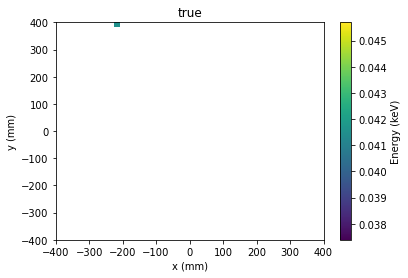

In [11]:
true_evt_x = true_evt.x
true_evt_y = true_evt.y
true_evt_e = true_evt.energy

plt.hist2d(true_evt_x, true_evt_y, bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=true_evt_e,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('true')
cb = plt.colorbar(label='Energy (keV)')

In [12]:
np.mean(true_evt_e)

0.0008478224044665694

In [21]:
filepath = '/Users/halmamol/NEXT/files/NFLEX/psf_202012/kr_penthesilea/'
filname_base = 'nflex_d15_M6_H6.kr83m'
filename = filepath+filname_base+f'.100.psf_hits_TEST.h5'
h5file = pd.read_hdf(filename, '/RECO/Events')
h5file
reco_evt = h5file[h5file.event == eventid]
reco_evt

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
11713,101802,0.0,0,-121.21231,217.049714,1,-217.70,388.75,0.000000e+00,0.000000e+00,707.181,102.318832,1361.986676,-1.0,-1.0,-1,-1.0
11714,101802,0.0,0,-121.21231,217.049714,1,-233.25,388.75,0.000000e+00,0.000000e+00,707.181,83.420288,1110.424329,-1.0,-1.0,-1,-1.0
11715,101802,0.0,0,-121.21231,217.049714,1,-217.70,404.30,0.000000e+00,0.000000e+00,707.181,80.869568,1076.471177,-1.0,-1.0,-1,-1.0
11716,101802,0.0,0,-121.21231,217.049714,1,-233.25,404.30,0.000000e+00,5.684342e-14,707.181,51.652176,687.552562,-1.0,-1.0,-1,-1.0
11717,101802,0.0,0,-121.21231,217.049714,1,-217.70,373.20,0.000000e+00,0.000000e+00,707.181,34.956520,465.313310,-1.0,-1.0,-1,-1.0
11718,101802,0.0,0,-121.21231,217.049714,1,-202.15,388.75,0.000000e+00,0.000000e+00,707.181,34.724636,462.226655,-1.0,-1.0,-1,-1.0
11719,101802,0.0,0,-121.21231,217.049714,1,-233.25,373.20,0.000000e+00,0.000000e+00,707.181,29.101450,387.375287,-1.0,-1.0,-1,-1.0
11720,101802,0.0,0,-121.21231,217.049714,1,-202.15,404.30,0.000000e+00,0.000000e+00,707.181,26.434782,351.878731,-1.0,-1.0,-1,-1.0
11721,101802,0.0,0,-121.21231,217.049714,1,-248.80,388.75,2.842171e-14,0.000000e+00,707.181,17.101448,227.640834,-1.0,-1.0,-1,-1.0
11722,101802,0.0,0,-121.21231,217.049714,1,-217.70,419.85,2.842171e-14,5.684342e-14,707.181,11.420290,152.017790,-1.0,-1.0,-1,-1.0


In [24]:
df = dstio.load_dsts([filename], 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], axis='columns').reset_index(drop=True)
df
df_evt = df[df.event == 101997]
df_evt

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E,Ep
14563,101997,0.0,0,213.109182,-14.032966,1,373.20,-15.55,1168.98225,91.246376,1326.157720,-1.0
14564,101997,0.0,0,213.109182,-14.032966,1,373.20,-31.10,1168.98225,88.057968,1279.817997,-1.0
14565,101997,0.0,0,213.109182,-14.032966,1,388.75,-31.10,1168.98225,46.550720,676.559439,-1.0
14566,101997,0.0,0,213.109182,-14.032966,1,388.75,-15.55,1168.98225,41.855072,608.313769,-1.0
14567,101997,0.0,0,213.109182,-14.032966,1,373.20,-46.65,1168.98225,37.971012,551.863570,-1.0
14568,101997,0.0,0,213.109182,-14.032966,1,357.65,-15.55,1168.98225,29.797102,433.065493,-1.0
14569,101997,0.0,0,213.109182,-14.032966,1,388.75,0.00,1168.98225,27.130434,394.308641,-1.0
14570,101997,0.0,0,213.109182,-14.032966,1,357.65,-31.10,1168.98225,23.304348,338.701024,-1.0
14571,101997,0.0,0,213.109182,-14.032966,1,388.75,-46.65,1168.98225,18.666666,271.297824,-1.0
14572,101997,0.0,0,213.109182,-14.032966,1,373.20,0.00,1168.98225,12.289855,178.618448,-1.0


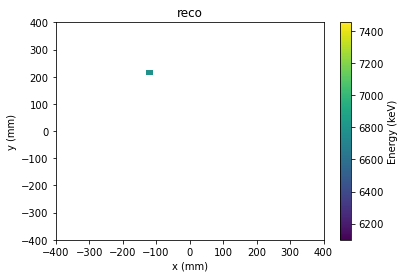

In [26]:
reco_evt_x = reco_evt.Xpeak
reco_evt_y = reco_evt.Ypeak
reco_evt_e = reco_evt.E

plt.hist2d(reco_evt_x, reco_evt_y, bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=reco_evt_e,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('reco')
cb = plt.colorbar(label='Energy (keV)')

In [136]:
df = dstio.load_dsts([filename], 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], axis='columns').reset_index(drop=True)
#for i in range (min(df.event), max(df.event)):
i=101066
c = []
df_evt = df[df.event == i]
df

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E,Ep
0,101000,0.0,0,248.903891,-66.651891,1,450.95,-108.85,448.368688,127.652168,1745.298777,-1.0
1,101000,0.0,0,248.903891,-66.651891,1,435.40,-108.85,448.368688,91.884064,1256.266511,-1.0
2,101000,0.0,0,248.903891,-66.651891,1,450.95,-124.40,448.368688,60.927540,833.019620,-1.0
3,101000,0.0,0,248.903891,-66.651891,1,450.95,-93.30,448.368688,56.753624,775.952589,-1.0
4,101000,0.0,0,248.903891,-66.651891,1,466.50,-108.85,448.368688,26.898550,367.765053,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14577,101997,0.0,0,213.109182,-14.032966,1,342.10,-15.55,1168.982250,7.014493,101.947326,-1.0
14578,101997,0.0,0,213.109182,-14.032966,1,404.30,0.00,1168.982250,6.840580,99.419700,-1.0
14579,101997,0.0,0,213.109182,-14.032966,1,357.65,0.00,1168.982250,6.666667,96.892081,-1.0
14580,101997,0.0,0,213.109182,-14.032966,1,373.20,-62.20,1168.982250,6.260869,90.994296,-1.0


In [137]:
df = dstio.load_dsts([filename], 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], axis='columns').reset_index(drop=True)
for i in range (min(df.event), max(df.event)+1):
    #i=101000
    #print(max(df.event))
    c_i, posXY, Qs = [], [], []
    df_evt = df[df.event == i]
    df_evt
    posXY = np.array([np.array([x,y]) for x,y in zip(df_evt.X, df_evt.Y)])
    Qs  = np.array(df_evt.Q)
    if (len(posXY) != 0):
        c_i = barycenter(posXY, Qs)
        df.loc[df['event'] == i, 'Xpeak']=c_i[0].X
        df.loc[df['event'] == i, 'Ypeak']=c_i[0].Y
    #df[df.event == i]
df

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Z,Q,E,Ep
0,101000,0.0,0,445.178579,-109.543832,1,450.95,-108.85,448.368688,127.652168,1745.298777,-1.0
1,101000,0.0,0,445.178579,-109.543832,1,435.40,-108.85,448.368688,91.884064,1256.266511,-1.0
2,101000,0.0,0,445.178579,-109.543832,1,450.95,-124.40,448.368688,60.927540,833.019620,-1.0
3,101000,0.0,0,445.178579,-109.543832,1,450.95,-93.30,448.368688,56.753624,775.952589,-1.0
4,101000,0.0,0,445.178579,-109.543832,1,466.50,-108.85,448.368688,26.898550,367.765053,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14577,101997,0.0,0,377.222885,-25.148561,1,342.10,-15.55,1168.982250,7.014493,101.947326,-1.0
14578,101997,0.0,0,377.222885,-25.148561,1,404.30,0.00,1168.982250,6.840580,99.419700,-1.0
14579,101997,0.0,0,377.222885,-25.148561,1,357.65,0.00,1168.982250,6.666667,96.892081,-1.0
14580,101997,0.0,0,377.222885,-25.148561,1,373.20,-62.20,1168.982250,6.260869,90.994296,-1.0


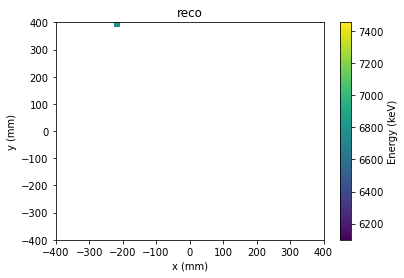

In [143]:
reco_evt_nw = df[df.event == eventid]

reco_evt_nw_x = reco_evt_nw.Xpeak
reco_evt_nw_y = reco_evt_nw.Ypeak
reco_evt_nw_e = reco_evt.E

plt.hist2d(reco_evt_nw_x, reco_evt_nw_y, bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=reco_evt_e,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('reco')
cb = plt.colorbar(label='Energy (keV)')

In [140]:
print(reco_evt.Q)
print(np.mean(reco_evt.Xpeak))
print(np.mean(reco_evt.Ypeak))
#xpos = np.mean(reco_evt.Xpeak)
#ypos = np.mean(reco_evt.Ypeak)
#print(xpos, ypos)

11713    102.318832
11714     83.420288
11715     80.869568
11716     51.652176
11717     34.956520
11718     34.724636
11719     29.101450
11720     26.434782
11721     17.101448
11722     11.420290
11723      8.057971
11724      6.492754
11725      6.376812
11726      5.855072
11727      5.275362
11728      5.043478
Name: Q, dtype: float64
-121.21230992693751
217.04971374478058


In [144]:
print(np.mean(reco_evt_nw.Xpeak))
print(np.mean(reco_evt_nw.Ypeak))

-222.95179927487862
392.4754841876369


In [18]:
print(c)

[< nsipm = 1 Q = 102.31884002685547
                    xy = xy(x=-217.7, y=388.75) 3dHit = Cluster(-217.7, 388.75, -9.425, E=102.31884002685547)  >, < nsipm = 1 Q = 83.4202880859375
                    xy = xy(x=-233.25, y=388.75) 3dHit = Cluster(-233.25, 388.75, -9.425, E=83.4202880859375)  >, < nsipm = 1 Q = 80.86956787109375
                    xy = xy(x=-217.7, y=404.3) 3dHit = Cluster(-217.7, 404.3, -9.425, E=80.86956787109375)  >, < nsipm = 1 Q = 51.65217208862305
                    xy = xy(x=-233.25, y=404.3) 3dHit = Cluster(-233.25, 404.3, -9.425, E=51.65217208862305)  >, < nsipm = 1 Q = 34.956520080566406
                    xy = xy(x=-217.7, y=373.2) 3dHit = Cluster(-217.7, 373.2, -9.425, E=34.956520080566406)  >, < nsipm = 1 Q = 34.72463607788086
                    xy = xy(x=-202.15, y=388.75) 3dHit = Cluster(-202.15, 388.75, -9.425, E=34.72463607788086)  >, < nsipm = 1 Q = 29.101449966430664
                    xy = xy(x=-233.25, y=373.2) 3dHit = Cluster(-233.25, 373.2, 

In [19]:
print(np.mean(true_evt.x))
print(np.mean(true_evt.y))
print(true_evt.energy)

-221.43698120117188
393.58758544921875
48893    0.001275
48894    0.000315
48895    0.000013
48896    0.000219
48897    0.000186
48898    0.003694
48899    0.000154
48900    0.001823
48901    0.000017
48902    0.000123
48903    0.000015
48904    0.001562
48905    0.003389
48906    0.000339
48907    0.000924
48908    0.000273
48909    0.000824
48910    0.001393
48911    0.000443
48912    0.002223
48913    0.001339
48914    0.003761
48915    0.000146
48916    0.000107
48917    0.000171
48918    0.000551
48919    0.000104
48920    0.000397
48921    0.000852
48922    0.001888
48923    0.000130
48924    0.000653
48925    0.000466
48926    0.000567
48927    0.000167
48928    0.000587
48929    0.000377
48930    0.001205
48931    0.000305
48932    0.000219
48933    0.001340
48934    0.000063
48935    0.000492
48936    0.000016
48937    0.000087
48938    0.000119
48939    0.000062
48940    0.003246
48941    0.002923
Name: energy, dtype: float32


In [145]:
reco_true_x, reco_true_y, reco_true_z = [], [], []

for nfile in range(100,150):
    
    #filename_reco = filepath+filname_base+f'.{nfile}.psf_hits.h5'
    h5file_reco = df
    
    filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_{nfile}_kr83m.h5'
    h5file_true = pd.read_hdf(filename, '/MC/hits')

    for nevent in range(0,999):
        diff_x, diff_y, diff_z = 0,0,0
        evt = (nfile+1)*1000 + nevent
        print(f'File {nfile}')
        print(f'Event id {evt}')
        reco_evt = h5file_reco[h5file_reco.event == evt]
        true_evt = h5file_true[h5file_true.event_id == evt]
        
        true_evt_x = true_evt.x
        true_evt_y = true_evt.y
        true_evt_z = true_evt.z
        true_evt_e = true_evt.energy
        
        try:
            true_bary_x = np.average(true_evt_x, weights=true_evt_e)
            true_bary_y = np.average(true_evt_y, weights=true_evt_e)
        except:
            continue
        
        try:
            reco_evt_x = reco_evt.Xpeak.values[0]
            reco_evt_y = reco_evt.Ypeak.values[0]
        except:
            continue
        
        diff_x = reco_evt_x - true_bary_x
        diff_y = reco_evt_y - true_bary_y
        
        print(f'True x {true_bary_x} Reco x {reco_evt_x}')
        
        reco_true_x.append(diff_x)
        reco_true_y.append(diff_y)
        reco_true_z.append(diff_z)

File 100
Event id 101000
True x 445.2093200683594 Reco x 445.17857881402864
File 100
Event id 101001
True x 358.52520751953125 Reco x 347.41197091302104
File 100
Event id 101002
True x -82.86546325683594 Reco x -81.20957691018846
File 100
Event id 101003
True x -423.54107666015625 Reco x -419.5722903577764
File 100
Event id 101004
True x 80.19926452636719 Reco x 79.57529471649036
File 100
Event id 101005
True x -203.8443145751953 Reco x -202.3925866660276
File 100
Event id 101006
True x 37.953060150146484 Reco x 38.58634542204673
File 100
Event id 101007
True x 319.06146240234375 Reco x 318.6225846402557
File 100
Event id 101008
True x -383.0634765625 Reco x -377.2152076517743
File 100
Event id 101009
True x -231.3243408203125 Reco x -232.6932646941844
File 100
Event id 101010
True x 235.28817749023438 Reco x 232.90794964681982
File 100
Event id 101011
True x 408.5661315917969 Reco x 406.9520725940935
File 100
Event id 101012
True x 136.90235900878906 Reco x 136.57031121647492
File 100

In [ ]:
filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_100_kr83m.h5'

S2Si = pd.read_hdf(filename, "/PMAPS/S2Si")
S2Si = S2Si.set_index(["event", "peak"])
# choose random event
#event = np.random.choice(S2Si.index.get_level_values("event").unique())
event = eventid
event_sipm_response = S2Si.loc[event, 0] # peak 0

charges = event_sipm_response.groupby("nsipm").ene.sum().to_frame()

select_sipms = datasipm.loc[charges.index.get_level_values("nsipm")]
xsipm, ysipm = select_sipms["X"].values, select_sipms["Y"].values

charge = charges["ene"].values
plt.hist2d(xsipm, ysipm,  bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=charge,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')

In [ ]:
xsipm


In [ ]:
filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_100_kr83m.h5'
h5file = pd.read_hdf(filename, '/PMAPS/S2Si')
h5file
pmaps_evt = h5file[h5file.event == eventid]
pmaps_evt

In [ ]:
datasipm

In [ ]:
datasipm_n100

In [ ]:
pmaps_evt_min = pmaps_evt[pmaps_evt.ene > 0.]
pmaps_evt_min

In [ ]:
events = len(pmaps_evt_min.event)
totalSiPM = len(datasipm)

allSiPM_x, allSiPM_y, allEnergy = [],[],[]
for i in range(0, events):
    print(f'{i}/{events}')
    SiPM_x = 0
    SiPM_y = 0
    nSiPM = pmaps_evt_min.nsipm.values[i]
    #print(nSiPM)
    for j in range(1,totalSiPM):
        #print(datasipm.SensorID.values[j])
        nSiPM_equiv = nSiPM + 1000
        #print(nSiPM_equiv)
        if(datasipm.SensorID.values[j]==nSiPM_equiv):
            print('SiPM encontrado!')
            SiPM_x = datasipm.X.values[j]
            SiPM_y = datasipm.Y.values[j]
            print(f'Pos = {SiPM_x},{SiPM_y}')
            continue
    if(SiPM_x == 0):
        continue

    allSiPM_x.append(SiPM_x)
    allSiPM_y.append(SiPM_y)
    allEnergy.append(pmaps_evt.ene.values[i])

In [ ]:
len(pmaps_evt[pmaps_evt.ene > 0.].ene)

In [ ]:
len(allEnergy)

In [ ]:
plt.hist2d(allSiPM_x, allSiPM_y,  bins=(50,50), 
           #range=((-400,-100),(-200,200)),
           weights=allEnergy,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')

In [ ]:
pmaps_evt_energ = pmaps_evt_min.ene

plt.hist(pmaps_evt_energ, bins = 50, range = (0.5, 10))

plt.xlabel('energy')
plt.ylabel('events (a.u.)')
plt.title('penthesilea')
plt.show()

In [ ]:
filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_100_kr83m.h5'
h5file_true = pd.read_hdf(filename, '/MC/hits')

true_evt = h5file_true[h5file_true.event_id == eventid]
true_evt 

In [ ]:
true_evt_x = true_evt.x
true_evt_y = true_evt.y
true_evt_e = true_evt.energy

In [ ]:
len(true_evt_x)

In [ ]:
plt.hist2d(true_evt_x, true_evt_y, bins=(50,50), 
           #range=((-400,-100),(-200,200)),
           weights=true_evt_e,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('true')
cb = plt.colorbar(label='Energy (keV)')

In [ ]:
plt.hist2d(reco_evt_x, reco_evt_y, bins=(50,50), 
           range=((-400,-100),(-200,200)),
           weights=reco_evt_e,cmin=0.0001)
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('reco')
cb = plt.colorbar(label='Energy (keV)')

In [ ]:
reco_true_x, reco_true_y, reco_true_z = [], [], []

for nfile in range(100,150):
    
    filename_reco = filepath+filname_base+f'.{nfile}.psf_hits.h5'
    h5file_reco = pd.read_hdf(filename_reco, '/RECO/Events')
    
    filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_{nfile}_kr83m.h5'
    h5file_true = pd.read_hdf(filename, '/MC/hits')

    for nevent in range(0,999):
        diff_x, diff_y, diff_z = 0,0,0
        evt = (nfile+1)*1000 + nevent
        print(f'File {nfile}')
        print(f'Event id {evt}')
        reco_evt = h5file_reco[h5file_reco.event == evt]
        true_evt = h5file_true[h5file_true.event_id == evt]
        
        true_evt_x = true_evt.x
        true_evt_y = true_evt.y
        true_evt_z = true_evt.z
        true_evt_e = true_evt.energy
        
        try:
            true_bary_x = np.average(true_evt_x, weights=true_evt_e)
            true_bary_y = np.average(true_evt_y, weights=true_evt_e)
        except:
            continue
        
        try:
            reco_evt_x = reco_evt.Xpeak.values[0]
            reco_evt_y = reco_evt.Ypeak.values[0]
        except:
            continue
        
        diff_x = reco_evt_x - true_bary_x
        diff_y = reco_evt_y - true_bary_y
        
        print(f'True x {true_bary_x} Reco x {reco_evt_x}')
        
        reco_true_x.append(diff_x)
        reco_true_y.append(diff_y)
        reco_true_z.append(diff_z)

In [ ]:
reco_true_x

In [ ]:
minr = np.amin(reco_true_x)
maxr = np.amax(reco_true_x)

plt.hist(reco_true_x, bins = 50, range = (minr, maxr))

plt.xlabel('reco[x] - true[x] (mm)')
plt.ylabel('events (a.u.)')
plt.title('penthesilea')
plt.show()

In [ ]:
minr = np.amin(reco_true_y)
maxr = np.amax(reco_true_y)

plt.hist(reco_true_y, bins = 50, range = (minr, maxr))

plt.xlabel('reco[y] - true[y] (mm)')
plt.ylabel('events (a.u.)')
plt.title('penthesilea')
plt.show()

## NEXT FLEX TEST

In [ ]:
filepath = '/Users/halmamol/NEXT/files/NFLEX/psf_202012/kr_penthesilea/'
filname_base = 'nflex_d15_M6_H6.kr83m'
maxnfiles = 999

In [ ]:
reco_true_x, reco_true_y, reco_true_z = [], [], []

for nfile in range(100,150):
    
    filename_reco = filepath+filname_base+f'.{nfile}.psf_hits_test.h5'
    h5file_reco = pd.read_hdf(filename_reco, '/RECO/Events')
    
    filename = f'/Users/halmamol/NEXT/files/NFLEX/hypathia_202012/hypathia_{nfile}_kr83m.h5'
    h5file_true = pd.read_hdf(filename, '/MC/hits')

    for nevent in range(0,999):
        diff_x, diff_y, diff_z = 0,0,0
        evt = (nfile+1)*1000 + nevent
        print(f'File {nfile}')
        print(f'Event id {evt}')
        reco_evt = h5file_reco[h5file_reco.event == evt]
        true_evt = h5file_true[h5file_true.event_id == evt]
        
        true_evt_x = true_evt.x
        true_evt_y = true_evt.y
        true_evt_z = true_evt.z
        true_evt_e = true_evt.energy
        
        try:
            true_bary_x = np.average(true_evt_x, weights=true_evt_e)
            true_bary_y = np.average(true_evt_y, weights=true_evt_e)
        except:
            continue
        
        try:
            reco_evt_x = reco_evt.Xpeak.values[0]
            reco_evt_y = reco_evt.Ypeak.values[0]
        except:
            continue
        
        diff_x = reco_evt_x - true_bary_x
        diff_y = reco_evt_y - true_bary_y
        
        print(f'True x {true_bary_x} Reco x {reco_evt_x}')
        
        reco_true_x.append(diff_x)
        reco_true_y.append(diff_y)
        reco_true_z.append(diff_z)

In [ ]:
minr = np.amin(reco_true_x)
maxr = np.amax(reco_true_x)

plt.hist(reco_true_x, bins = 50, range = (minr, maxr))

plt.xlabel('reco[x] - true[x] (mm)')
plt.ylabel('events (a.u.)')
plt.title('penthesilea')
plt.show()

In [ ]:
minr = np.amin(reco_true_y)
maxr = np.amax(reco_true_y)

plt.hist(reco_true_y, bins = 50, range = (minr, maxr))

plt.xlabel('reco[y] - true[y] (mm)')
plt.ylabel('events (a.u.)')
plt.title('penthesilea')
plt.show()

## NEXT 100

In [ ]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/psf_202012/kr_penthesilea/'
filname_base = 'next100.kr83m'
maxnfiles = 999

In [ ]:
filename = f'/Users/halmamol/NEXT/files/NEXT100/hypathia_202012/hypathia_100_kr83m.h5'

S2Si = pd.read_hdf(filename, "/PMAPS/S2Si")
S2Si = S2Si.set_index(["event", "peak"])
# choose random event
#event = np.random.choice(S2Si.index.get_level_values("event").unique())
event = 101625
event_sipm_response = S2Si.loc[event, 0] # peak 0

charges = event_sipm_response.groupby("nsipm").ene.sum().to_frame()

select_sipms = datasipm_n100.loc[charges.index.get_level_values("nsipm")]
xsipm, ysipm = select_sipms["X"].values, select_sipms["Y"].values
charge = charges["ene"].values
plt.hist2d(xsipm, ysipm,  bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=charge,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')


In [ ]:
filename = f'/Users/halmamol/NEXT/files/NEXT100/hypathia_202012/hypathia_100_kr83m.h5'

S2Si = pd.read_hdf(filename, "/PMAPS/S2Si")
S2Si = S2Si.set_index(["event", "peak"])
# choose random event
#event = np.random.choice(S2Si.index.get_level_values("event").unique())
event = 101625
event_sipm_response = S2Si.loc[event, 0] # peak 0

charges = event_sipm_response.groupby("nsipm").ene.sum().to_frame()
charges_th = charges[charges.ene > 5.]

select_sipms = datasipm_n100.loc[charges_th.index.get_level_values("nsipm")]
xsipm, ysipm = select_sipms["X"].values, select_sipms["Y"].values
charge = charges_th["ene"].values
plt.hist2d(xsipm, ysipm,  bins=(50,50), 
           range=((-400,400),(-400,400)),
           weights=charge,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')

In [ ]:
plt.hist2d(xsipm, ysipm,  bins=(50,50), 
           #range=((-400,-100),(-200,200)),
           weights=charge,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')

In [ ]:
filename = f'/Users/halmamol/NEXT/files/NEXT100/hypathia_202012/hypathia_100_kr83m.h5'
h5file = pd.read_hdf(filename, '/PMAPS/S2Si')
h5file
pmaps_evt = h5file[h5file.event == eventid]
pmaps_evt

In [ ]:
pmaps_evt_min = pmaps_evt[pmaps_evt.ene > 0.]
pmaps_evt

In [ ]:
events = len(pmaps_evt_min.event)
totalSiPM = len(datasipm)

allSiPM_x, allSiPM_y, allEnergy = [],[],[]
for i in range(0, events):
    print(f'{i}/{events}')
    SiPM_x = 0
    SiPM_y = 0
    nSiPM = pmaps_evt_min.nsipm.values[i]
    #print(nSiPM)
    for j in range(1,totalSiPM):
        #print(datasipm.SensorID.values[j])
        nSiPM_equiv = nSiPM + 1000
        #print(nSiPM_equiv)
        if(datasipm.SensorID.values[j]==nSiPM_equiv):
            print('SiPM encontrado!')
            SiPM_x = datasipm.X.values[j]
            SiPM_y = datasipm.Y.values[j]
            print(f'Pos = {SiPM_x},{SiPM_y}')
            continue
    if(SiPM_x == 0):
        continue

    allSiPM_x.append(SiPM_x)
    allSiPM_y.append(SiPM_y)
    allEnergy.append(pmaps_evt.ene.values[i])

In [ ]:
plt.hist2d(allSiPM_x, allSiPM_y,  bins=(50,50), 
           #range=((-400,-100),(-200,200)),
           weights=allEnergy,cmin=0.0001)

plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.title('SiPM info')
cb = plt.colorbar(label='Energy (keV)')

In [ ]:
filename = filepath+filname_base+f'.100.psf_hits.h5'
h5file = pd.read_hdf(filename, '/RECO/Events')
h5file
reco_evt = h5file[h5file.event == 101963]
reco_evt

In [ ]:
filename = f'/Users/halmamol/NEXT/files/NEXT100/hypathia_202012/hypathia_100_kr83m.h5'
h5file = pd.read_hdf(filename, '/MC/hits')
h5file
true_evt = h5file[h5file.event_id == 101963]
true_evt

In [ ]:
reco_true_x, reco_true_y, reco_true_z = [], [], []

for nfile in range(100,150):
    
    filename = filepath+filname_base+f'.{nfile}.psf_hits.h5'
    h5file_reco = pd.read_hdf(filename, '/RECO/Events')
    
    filename = f'/Users/halmamol/NEXT/files/NEXT100/hypathia_202012/hypathia_{nfile}_kr83m.h5'
    h5file_true = pd.read_hdf(filename, '/MC/hits')

    for nevent in range(0,999):
        diff_x, diff_y, diff_z = 0,0,0
        evt = (nfile+1)*1000 + nevent
        print(f'File {nfile}')
        print(f'Event id {evt}')
        reco_evt = h5file_reco[h5file_reco.event == evt]
        true_evt = h5file_true[h5file_true.event_id == evt]
        
        true_evt_x = true_evt.x
        true_evt_y = true_evt.y
        true_evt_z = true_evt.z
        true_evt_e = true_evt.energy
        
        try:
            true_bary_x = np.average(true_evt_x, weights=true_evt_e)
            true_bary_y = np.average(true_evt_y, weights=true_evt_e)
        except:
            continue
        
        try:
            reco_evt_x = reco_evt.Xpeak.values[0]
            reco_evt_y = reco_evt.Ypeak.values[0]
        except:
            continue
        
        diff_x = reco_evt_x - true_bary_x
        diff_y = reco_evt_y - true_bary_y
        
        print(f'True x {true_bary_x} Reco x {reco_evt_x}')
        
        reco_true_x.append(diff_x)
        reco_true_y.append(diff_y)
        reco_true_z.append(diff_z)

In [ ]:
reco_true_x

In [ ]:
minr = np.amin(reco_true_x)
maxr = np.amax(reco_true_x)

plt.hist(reco_true_x, bins = 50, range = (minr, maxr))

plt.xlabel('reco[x] - true[x] (mm)')
plt.ylabel('events (a.u.)')
plt.title('penthesilea')
plt.show()

In [ ]:
minr = np.amin(reco_true_y)
maxr = np.amax(reco_true_y)

plt.hist(reco_true_y, bins = 50, range = (minr, maxr))

plt.xlabel('reco[y] - true[y] (mm)')
plt.ylabel('events (a.u.)')
plt.title('penthesilea')
plt.show()